# The shark: noscore games

The one factor having the biggest impact on the profits/losses for the LTD strategy is the number of games that do not see a goal after jumping in. When jumping in at T=0, these are the 0-0 games. Unfortunately these 'noscore games' are unevenly distributed in our sample dataset, heavily distorting the conclusions from our analysis. In this notebook we will investigate this.

## Data and routines

In [44]:
#setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import timeit

In [45]:
#Read in data
df = pd.read_csv('../1 data preparation/20190401-20200312_items_prepped.csv')

In [3]:
def profit_table(df, LTD_start = 0, target_profit = 0.10, underdog_lead_target_profit = 0.10, profit_commission = 0.065,
                 back_F_qcut = [0, .25, .5, .75, 1.], back_noscore_qcut = [0, .20, .75, 1.], Q_beat = None, 
                 underdog_lead_overwrite = True):
    '''
    This function takes in the whole prepped dataframe and some strategy parameters:
    - LTD_start = when to start the strategy. Possible values: 0, 15, 30, 45, 60 or 75. Default 0.
    - target_profit = profit percentage at which bet closure takes place. Value between 0 and 1. Default 0.10.
    - underdog_lead_target_profit = profit percentage at which bet closure takes place, when underdog leads. Value between 0 and 1. Default 0.10.
    - profit_commission = bookie margin taken on net profit. Default 6.5%
    - back_F_qcut = list quantiles to create back_F categories. Default [0, .25, .5, .75, 1.]
    - back_noscore_qcut = list quantiles to create back_noscore categories. Default [0, .20, .75, 1.]
    
    The routine returns the dataframe enriched with data for profit analysis.
    '''
    
    #init
    df_in = df.copy()
    
    #determine Q_beat based on target_profit
    df_in['return_lay'] = 1 / (df_in['lay_X'] - 1)
    df_in['target_profit'] = target_profit
    df_in['stake_close_max'] = df_in['return_lay'] - df_in['target_profit'] #maximum stake for closing the bet, making target_profit
    if (Q_beat is None):
        df_in['Q_beat'] = (df_in['lay_X'] / (1 - (df_in['lay_X'] - 1) * df_in['target_profit'])).round(2)
    else:
        df_in['Q_beat'] = Q_beat
    df_in['profit_Q_beat'] = df_in['Q_beat'] * df_in['stake_close_max'] - 1 - df_in['stake_close_max'] #approx equal to target_profit
    df_in.loc[(df_in['market_name'] != 'Match Odds'),'Q_beat'] = np.nan
    
    #determine the gametags with score = draw at LTD_start
    play_tags = df_in[(df_in['mins15'] == LTD_start) & (df_in['score_diff_label'] == 'F+0')]['gametag'].unique()

    #determine Close and Q_close based on LTD_start
    for (count,gametag) in enumerate(play_tags):
        #sub1: all Match Odds observations for this game, after LTD_start
        ltdstart_row_idx = df_in[(df_in['gametag'] == gametag) & (df_in['mins15'] == LTD_start)].index[0]
        df_sub = df_in[(df_in['gametag'] == gametag) & (df_in['market_name'] == 'Match Odds')].loc[ltdstart_row_idx:,:]
        #set Q-beat equal to the Q_beat at LTD_start for all observations
        df_sub.loc[:,'Q_beat'] = df_sub[(df_sub['mins15'] == LTD_start)]['Q_beat'].iloc[0]
        #overwrite Q_beat for observations where the underdog is leading
        if underdog_lead_overwrite:
            lay_X = df_sub[(df_sub['mins15'] == LTD_start)]['lay_X'].iloc[0]
            Q_beat_und = (lay_X / (1 - (lay_X - 1) * underdog_lead_target_profit)).round(2)
            df_sub.loc[(df_sub['score_diff_label'].str[0:2] == "F-"),'Q_beat'] = Q_beat_und
            df_sub.loc[(df_sub['score_diff_label'].str[0:2] == "F-"),'target_profit'] = underdog_lead_target_profit
        #sub2: all observations with back_X >= Q_beat
        df_sub = df_sub[df_sub['back_X'] >= df_sub['Q_beat']]
        #store Close and Q_close
        if (df_sub.shape[0] == 0):
            df_in.loc[ltdstart_row_idx,'Close'] = False
            df_in.loc[ltdstart_row_idx,'Q_close'] = np.nan
            df_in.loc[ltdstart_row_idx,'gametime_close'] = np.nan
        else:
            df_in.loc[ltdstart_row_idx,'Close'] = True
            df_in.loc[ltdstart_row_idx,'Q_close'] = df_sub['back_X'].iloc[0]
            df_in.loc[ltdstart_row_idx,'gametime_close'] = df_sub['current_gametime_T2'].iloc[0]
            df_in.loc[ltdstart_row_idx,'target_profit'] = df_sub['target_profit'].iloc[0]
            df_in.loc[ltdstart_row_idx,'stake_close_max'] = df_in.loc[ltdstart_row_idx,'return_lay'] - df_in.loc[ltdstart_row_idx,'target_profit']
    
    #outcome
    df_in.loc[(df_in['endscore_label'] == 'F+0') & (df_in['Close'] == False),'outcome'] = 'open_loss'
    df_in.loc[(df_in['endscore_label'] != 'F+0') & (df_in['Close'] == False),'outcome'] = 'open_win'
    df_in.loc[(df_in['Close'] == True),'outcome'] = 'closed_win'
    #closed_win
    df_in.loc[df_in['outcome'] == 'closed_win','stake_close'] = (1+df_in['target_profit']+ df_in['stake_close_max'])/(df_in['Q_close']) #stake needed for closing the bet, making target_profit
    df_in.loc[df_in['outcome'] == 'closed_win','profit_close'] = df_in['target_profit'] + df_in['stake_close_max'] - df_in['stake_close']
    #open_loss
    df_in.loc[df_in['outcome'] == 'open_loss','profit_close'] = -1
    #open_win
    df_in.loc[df_in['outcome'] == 'open_win','profit_close'] = df_in['return_lay']
    
    #net profit
    df_in.loc[df_in['profit_close'] > 0,'net_profit'] = df_in['profit_close'] * (1-profit_commission)
    df_in.loc[df_in['profit_close'] <= 0,'net_profit'] = df_in['profit_close']
    
    #create back_F factors
    df_in.loc[:,'back_F_factor'] = pd.qcut(df_in[(df_in['mins15'] == LTD_start) & (df_in['score_diff_label'] == 'F+0')]['back_F'], 
                                                   q = back_F_qcut)
    
    #back_noscore_calib cut made for each back_F category seperately
    for F_interval in df_in['back_F_factor'].unique().dropna():
        df_in.loc[(df_in['back_F_factor'] == F_interval),
               'back_noscore_calib_factor'] = pd.qcut(df_in[df_in['back_F_factor'] == F_interval]['back_noscore_calib'], 
                                                        q = back_noscore_qcut, labels=np.arange(1,len(back_noscore_qcut),1))
    
    return df_in

In [4]:
def profit_pivot(df, aggreg_function = 'mean'):
    '''
    Function that makes the pivot table of net_profit values for back_F_factor and back_noscore_calib_factor categories
    aggreg_function values are: 'sum', 'mean', 'count'
    '''
    if (aggreg_function == 'count'):
        func = lambda x: len(x)
    else:
        func = aggreg_function
    
    return df.pivot_table(values='net_profit',index='back_F_factor',columns='back_noscore_calib_factor',aggfunc=func,margins=True)

In [5]:
def profit_game_summary(df):
    '''
    Function that creates an overview of the profit calculation per game for a given profit_table
    '''
    return df[~df['net_profit'].isnull()][['gametag','current_score_T2','back_F','back_F_factor','back_noscore_calib','back_noscore_calib_factor',
                                            'back_X','lay_X','Q_beat','return_lay','target_profit','stake_close_max',
                                            'endscore','Close','gametime_close','Q_close','stake_close','profit_close','net_profit']]

In [6]:
def profit_barplot(df):
    p = plt.figure(figsize=(40,6))
    p = sns.barplot(data=df[(~df['net_profit'].isnull())],x='gametag',y='net_profit',hue='outcome')
    plt.legend(fontsize = 'xx-large')
    p.set_xticklabels("");
    return p

### 'Winning' strategies as concluded from the first LTD analysis:

<img src="../0 images/ltd_subgroups_overview.png">

In [7]:
#list of strategy 1 profit tables
start = timeit.default_timer()
starts = [0,15,30,45,60,75]
strat_1_tables = [profit_table(df,LTD_start=x,underdog_lead_target_profit = 0.10) for x in starts]
stop = timeit.default_timer()
print('Runtime: ', stop - start)

C:\Users\nverd\anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in double_scalars


Runtime:  98.38351940000001


In [8]:
#list of strategy 2 profit tables
start = timeit.default_timer()
starts = [0,15,30,45,60,75]
strat_2_tables = [profit_table(df,LTD_start=x,underdog_lead_target_profit = 0) for x in starts]
stop = timeit.default_timer()
print('Runtime: ', stop - start)

Runtime:  98.91927529999998


In [9]:
strat_1_sum_pivots = [profit_pivot(x, aggreg_function = 'sum') for x in strat_1_tables]
strat_2_sum_pivots = [profit_pivot(x, aggreg_function = 'sum') for x in strat_2_tables]
strat_1_count_pivots = [profit_pivot(x, aggreg_function = 'count') for x in strat_1_tables]
strat_2_count_pivots = [profit_pivot(x, aggreg_function = 'count') for x in strat_2_tables]
strat_1_mean_pivots = [profit_pivot(x, aggreg_function = 'mean') for x in strat_1_tables]
strat_2_mean_pivots = [profit_pivot(x, aggreg_function = 'mean') for x in strat_2_tables]

In [10]:
#profit per game summaries
strat_1_game_summaries = [profit_game_summary(x) for x in strat_1_tables]
strat_2_game_summaries = [profit_game_summary(x) for x in strat_2_tables]

## Problematic observation for our 'winning' F+++ category

This category (F+++, T=0: medium scoring likelihood [11.50-17.00]) has **only 5 noscoring games**, out of 110 observations (4,55%):

In [11]:
st = strat_1_game_summaries[0]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[1]
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 2)]
print('game count: ',st_sub.shape[0])
print('0-0 games: ',st_sub[st_sub['endscore'] == '0-0'].shape[0])
print('Percentage: ',np.round(st_sub[st_sub['endscore'] == '0-0'].shape[0] / st_sub.shape[0],4))

game count:  110
0-0 games:  5
Percentage:  0.0455


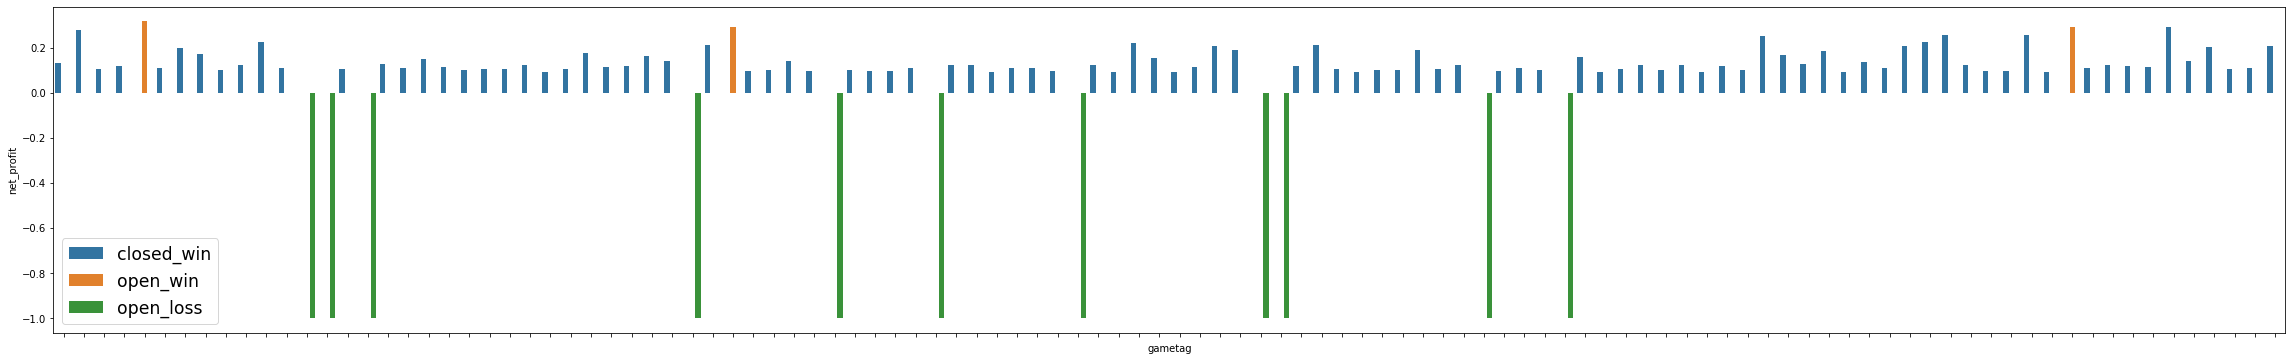

In [12]:
df_sub2 = strat_1_tables[0].copy()
df_sub2 = df_sub2[(df_sub2['back_F_factor'] == df_sub2['back_F_factor'].unique().dropna().sort_values()[1]) 
                           & (df_sub2['back_noscore_calib_factor'] == 2)]
df_sub_game_sum = profit_game_summary(df_sub2)
df_sub_game_sum.to_excel('./output/strat_1_mins0_mediumhigh_fav_medium_sl_game_summaries.xlsx',index=False)
profit_barplot(df_sub2)

This while the **average back_noscore quote is 13.96**, implying an **expected percentage of noscore games of 7.88**:

In [13]:
print('Average back_noscore quote: ',np.round(st_sub['back_noscore_calib'].mean(),2))
print('Expected percentage of noscore games: ', np.round(1/st_sub['back_noscore_calib'].mean(),4))
print('Expected number of noscore games: ', np.round(st_sub.shape[0]/st_sub['back_noscore_calib'].mean(),2))

Average back_noscore quote:  13.96
Expected percentage of noscore games:  0.0716
Expected number of noscore games:  7.88


We expected 3 more 0-0 games for this category, making it 8 out of 113. These games have a guaranteed profit of -1. 

The **sum net profit** 2.88 becomes -0.12:

In [14]:
print('Sum net profit for this category in our sample: ', np.round(st_sub['net_profit'].sum(),2))
print('Sum net profit for this category, corrected: ', np.round(st_sub['net_profit'].sum() - 3, 2))

Sum net profit for this category in our sample:  2.88
Sum net profit for this category, corrected:  -0.12


## F++++ category

In [15]:
st = strat_1_game_summaries[0]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[0]
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 2)]
print('game count: ',st_sub.shape[0])
print('0-0 games: ',st_sub[st_sub['endscore'] == '0-0'].shape[0])
print('Percentage: ',np.round(st_sub[st_sub['endscore'] == '0-0'].shape[0] / st_sub.shape[0],4))

game count:  116
0-0 games:  1
Percentage:  0.0086


In [16]:
print('Average back_noscore quote: ',np.round(st_sub['back_noscore_calib'].mean(),2))
print('Expected percentage of noscore games: ', np.round(1/st_sub['back_noscore_calib'].mean(),4))
print('Expected number of noscore games: ', np.round(st_sub.shape[0]/st_sub['back_noscore_calib'].mean(),2))

Average back_noscore quote:  19.17
Expected percentage of noscore games:  0.0522
Expected number of noscore games:  6.05


In [17]:
print('Sum net profit for this category in our sample: ', np.round(st_sub['net_profit'].sum(),2))

Sum net profit for this category in our sample:  9.71


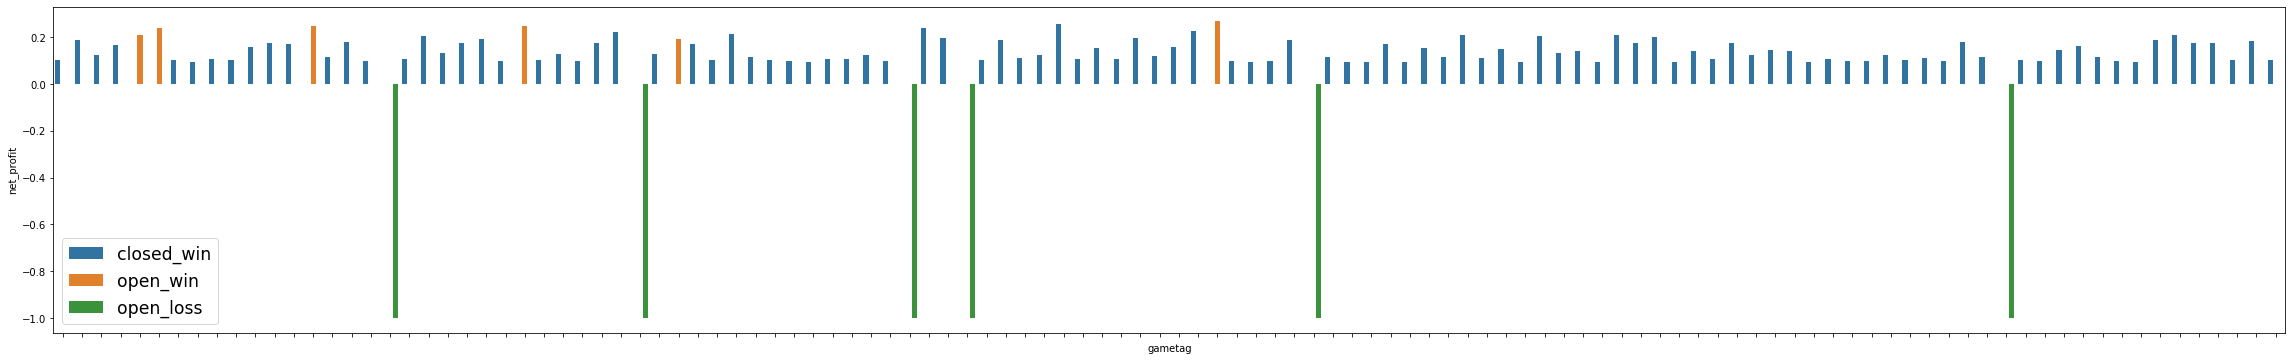

In [18]:
df_sub2 = strat_1_tables[0].copy()
df_sub2 = df_sub2[(df_sub2['back_F_factor'] == df_sub2['back_F_factor'].unique().dropna().sort_values()[0]) 
                           & (df_sub2['back_noscore_calib_factor'] == 2)]
df_sub_game_sum = profit_game_summary(df_sub2)
df_sub_game_sum.to_excel('./output/strat_1_mins0_high_fav_medium_sl_game_summaries.xlsx',index=False)
profit_barplot(df_sub2)

## F+ category

For our other 'winning' category (F+, T=30: low scoring likelihood [0, 8.40]) the **under-representation of nonscoring games** is even worse. We actually have 1 out of 25 games:

In [19]:
st = strat_2_game_summaries[2]
fav_cat = st['back_F_factor'].unique().dropna().sort_values()[3]
st_sub = st[(st['back_F_factor'] == fav_cat) & (st['back_noscore_calib_factor'] == 1)]
print('game count: ',st_sub.shape[0])
print('0-0 games: ',st_sub[st_sub['endscore'] == '0-0'].shape[0])
print('Percentage: ',np.round(st_sub[st_sub['endscore'] == '0-0'].shape[0] / st_sub.shape[0],4))

game count:  25
0-0 games:  1
Percentage:  0.04


On a sidenote: we even 'managed' to close out this game as there was a disallowed goal and jump in back_X in minute 43. It is questionable whether this was possible in practice, so this might have further 'improved' our results. But that aside, we also expected many more non scoring games for this category. At T=0, the average back_noscore was 7.41, implying a 13,5% chance on 0-0, so 3 to 4 out of 25:

In [20]:
print('Average back_noscore quote: ',np.round(st_sub['back_noscore_calib'].mean(),2))
print('Expected percentage of noscore games: ', np.round(1/st_sub['back_noscore_calib'].mean(),4))
print('Expected number of noscore games: ', np.round(st_sub.shape[0]/st_sub['back_noscore_calib'].mean(),2))

Average back_noscore quote:  7.41
Expected percentage of noscore games:  0.1349
Expected number of noscore games:  3.37


Adding 3 to 4 extra non scoring games will already eat much of our profit for this category (5.92).

Moreover, note that we play this strategy at T=30, when the back_noscore is already significantly lower than at T=0, implying an even higher expected number of non scoring games.

In [21]:
print('Sum net profit for this category in our sample: ', np.round(st_sub['net_profit'].sum(),2))

Sum net profit for this category in our sample:  5.92


#### Conclusion

Actually for all our 'winning' game categories we find an under representation of non scoring games. This significantly impacts the conclusion of our first analysis. 

Of course, for other categories there might be an over-representation as well. We can explore and correct our results for every category.

## Calculating the actual and expected number of noscore games per category (T=0)

In [29]:
#new attribute in all of our profit tables: 'noscore_game' (games where endscore equals current score)
noscore_games = [(x['current_score_T2'] == x['endscore']) for x in strat_1_tables]
for i in np.arange(0,6,1):
    strat_1_tables[i].loc[:,'noscore_game'] = noscore_games[i]
    strat_2_tables[i].loc[:,'noscore_game'] = noscore_games[i]

#### Actual number of noscore games

In [30]:
#actual number of noscore games per category at T=0
st = strat_1_tables[0]
actual_noscore_count = st.pivot_table(values='noscore_game',index='back_F_factor',
                                      columns='back_noscore_calib_factor',aggfunc=sum,margins=True)
actual_noscore_count

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.1190000000000002, 1.688]",3.0,1.0,2.0,6.0
"(1.688, 1.97]",7.0,5.0,3.0,15.0
"(1.97, 2.3]",5.0,14.0,4.0,23.0
"(2.3, 3.0]",2.0,9.0,3.0,14.0
All,17.0,29.0,12.0,58.0


#### Expected number of noscore games

The expected percentage of noscore games is equal to 1 divided by the average back_noscore quote at T=0 (back_noscore_calib) per category:

In [23]:
#mean back_noscore_calib per category
mean_back_noscores = st.pivot_table(values='back_noscore_calib',index='back_F_factor',
                                 columns='back_noscore_calib_factor',aggfunc='mean',margins=True)
mean_back_noscores.round(2)

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.1190000000000002, 1.688]",12.51,19.17,32.88,21.04
"(1.688, 1.97]",9.62,13.96,20.57,14.58
"(1.97, 2.3]",8.24,12.93,19.01,13.31
"(2.3, 3.0]",7.14,11.61,18.01,12.10
All,9.36,14.43,22.69,15.27


In [25]:
#expected percentage of noscore games, based on back_noscore_calib
exp_noscore_perc = 1 / mean_back_noscores *100
exp_noscore_perc.round(2)

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.1190000000000002, 1.688]",7.99,5.22,3.04,4.75
"(1.688, 1.97]",10.40,7.16,4.86,6.86
"(1.97, 2.3]",12.13,7.73,5.26,7.51
"(2.3, 3.0]",14.00,8.62,5.55,8.26
All,10.68,6.93,4.41,6.55


In [26]:
#expected number of noscore games
exp_noscore_count = strat_1_count_pivots[0] * exp_noscore_perc/100 #element by element product
exp_noscore_count.round(2)

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.1190000000000002, 1.688]",3.52,6.05,1.52,9.98
"(1.688, 1.97]",5.20,7.88,2.58,14.60
"(1.97, 2.3]",5.34,9.28,2.47,15.86
"(2.3, 3.0]",6.44,9.65,2.67,17.02
All,19.65,31.73,8.73,55.01


The difference between the actual and expected number of noscore games per category:

In [31]:
actual_exp_noscore_diff = actual_noscore_count - exp_noscore_count
actual_exp_noscore_diff.round(2)

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.1190000000000002, 1.688]",-0.52,-5.05,0.48,-3.98
"(1.688, 1.97]",1.80,-2.88,0.42,0.40
"(1.97, 2.3]",-0.34,4.72,1.53,7.14
"(2.3, 3.0]",-4.44,-0.65,0.33,-3.02
All,-2.65,-2.73,3.27,2.99


#### Corrected results

So indeed quite an under representation for the categories we had selected as 'winning' categories.

If we believe in the back_noscore quotes representing the actual probabilities on a noscore game*, we can correct our strategy results based on this.

'* this is a fair assumption. however an even better indicator would be the mid between the back and lay quote. we will use this  'midmarket' below when we do the calculations for all the categories at all T's

In [32]:
#original results
strat_1_sum_pivots[0]

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.1190000000000002, 1.688]",-1.430168,9.706771,-0.440652,7.835951
"(1.688, 1.97]",-5.225493,2.875257,1.213387,-1.136848
"(1.97, 2.3]",-1.642105,-13.060802,-3.219302,-17.922209
"(2.3, 3.0]",2.484891,-3.905084,-2.169658,-3.589851
All,-5.812875,-4.383857,-4.616224,-14.812956


In [33]:
#results corrected for under/over representation of noscore games per category
strat_1_sum_pivots[0] + actual_exp_noscore_diff

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.1190000000000002, 1.688]",-1.947227,4.656412,0.038667,3.855098
"(1.688, 1.97]",-3.422998,-0.004912,1.636323,-0.741387
"(1.97, 2.3]",-1.981322,-8.340946,-1.691602,-10.778395
"(2.3, 3.0]",-1.956509,-4.554315,-1.834782,-6.611912
All,-8.467342,-7.112439,-1.343740,-11.827240


We see that after correction, the losses are more equally distributed and there are **few remaining 'winning game categories' at T=0**. Remember we had already excluded the F+++/mid-SL/T0 category already because our LTD strategy did not perform better than the 'lay and go' strategy.

## T=15, T=30, T=45, T=60, T=75

The back_noscore quote will generally decline with time passing by. This means that for T different from 0, the back_noscore_calib (T=0) quote will give an underestimation of the probability there will be no more goal scored in the remainder of the game.

The probability of a noscore game after T=0 is best derived from the **midmarket (middle between back and lay) noscore quote**:

In [46]:
#new attribute for the whole df: midmarket_noscore
df['midmarket_noscore'] = (df['back_noscore'] + df['lay_noscore'])/2

In [47]:
#calculate the 99% upper quantile so we can exclude outliers in the next step
quantiles = pd.DataFrame(data=np.zeros((91,1)), index = np.arange(0,91,1), columns = ['midmarket_noscore_q98'])
for gametime in quantiles.index:
    quantiles.iloc[gametime,0] = df[df['current_gametime_T2'] == gametime]['midmarket_noscore'].quantile(0.98)
quantiles.reset_index(drop=False,inplace=True)
quantiles.columns = ['current_gametime_T2','midmarket_noscore_q98']
quantiles['market_name'] = 'Correct Score'

df = df.merge(quantiles,how='left',on=['market_name','current_gametime_T2'])

In [48]:
#exclude outliers
df.loc[((df['midmarket_noscore'] >= 100) | 
         (df['midmarket_noscore'] >= df['midmarket_noscore_q98'])), 'midmarket_noscore'] = np.nan

In [49]:
#collect the 'back_F_factor' and 'back_noscore_calib_factor' per gametag
game_categories = strat_1_tables[0].groupby('gametag')[['back_F_factor','back_noscore_calib_factor']].first().dropna()
game_categories.reset_index(drop=False, inplace=True)

In [50]:
#add 'back_F_factor' and 'back_noscore_calib_factor' to df
df = df.merge(game_categories,how='left',on='gametag')

In [51]:
df[df['mins15'] == 0].pivot_table(values='gametag',index='back_F_factor',columns='back_noscore_calib_factor',
                                            aggfunc='count',margins=True)

back_noscore_calib_factor,1.0,2.0,3.0,All
back_F_factor,,,,
"(1.1190000000000002, 1.688]",44,116,50,210
"(1.688, 1.97]",50,110,53,213
"(1.97, 2.3]",44,120,47,211
"(2.3, 3.0]",46,112,48,206
All,184,458,198,840


We can do a regression on the evolution of these midmarket_noscores over gametime:

In [52]:
#filter out the desired game observations for our regression
df_sub = df[(df['market_name'] == 'Correct Score') & (df['current_gametime_T2'] >= 0)
          & (df['current_gametime_T2'] <= 90) & (df['score_diff_label'] == 'F+0') & (~df['midmarket_noscore'].isnull())]
df_sub[['gametag','market_name','current_gametime_T2','back_noscore_calib','back_noscore','lay_noscore','midmarket_noscore']].head()

,gametag,market_name,current_gametime_T2,back_noscore_calib,back_noscore,lay_noscore,midmarket_noscore
97,20190401_ARSNEW,Correct Score,0.0,21.0,21.0,22.0,21.5
100,20190401_ARSNEW,Correct Score,2.0,21.0,21.0,22.0,21.5
103,20190401_ARSNEW,Correct Score,4.0,21.0,21.0,22.0,21.5
110,20190401_ARSNEW,Correct Score,10.0,21.0,16.0,17.0,16.5
114,20190401_ARSNEW,Correct Score,12.0,21.0,15.0,16.0,15.5


<Figure size 576x288 with 0 Axes>

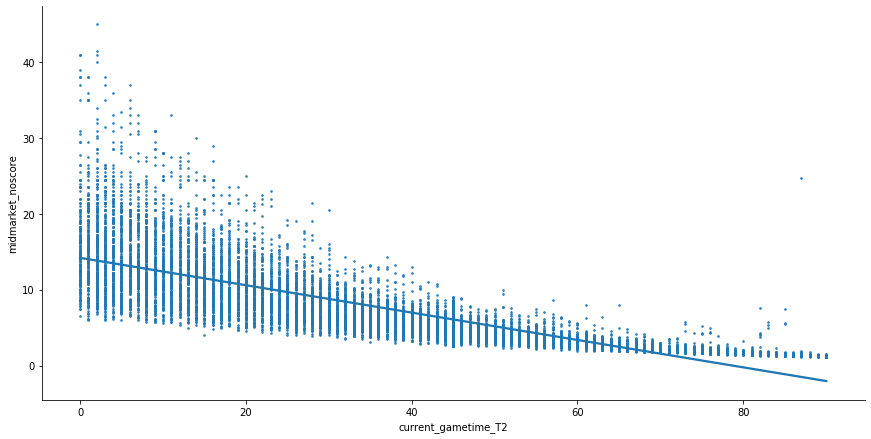

In [55]:
plt.figure(figsize=(8,4))
sns.lmplot(data=df_sub, x='current_gametime_T2', y= 'midmarket_noscore', scatter_kws = {'s':3}, aspect = 2, height=6)

## Linear regression per timebucket

The linear regression does not seem to fully grasp the true relationship between the noscore quote and time. The true relationship is more degressive. To get to better estimates we can also perform a linear regression per time bucket:

In [56]:
#new attribute 'timebucket'
df.loc[((df['current_gametime_T2'] > -1 ) & (df['current_gametime_T2'] <= 7)),'timebucket'] = 0
df.loc[((df['current_gametime_T2'] > 7) & (df['current_gametime_T2'] <= 22)),'timebucket'] = 15
df.loc[((df['current_gametime_T2'] > 22) & (df['current_gametime_T2'] <= 37)),'timebucket'] = 30
df.loc[((df['current_gametime_T2'] > 37) & (df['current_gametime_T2'] <= 52)),'timebucket'] = 45
df.loc[((df['current_gametime_T2'] > 52) & (df['current_gametime_T2'] <= 67)),'timebucket'] = 60
df.loc[((df['current_gametime_T2'] > 67) & (df['current_gametime_T2'] <= 82)),'timebucket'] = 75
df.loc[((df['current_gametime_T2'] > 82) & (df['current_gametime_T2'] <= 90)),'timebucket'] = 90

In [57]:
#filter out the desired game observations
df_sub = df[(df['market_name'] == 'Correct Score') & (df['current_gametime_T2'] >= 0)
          & (df['current_gametime_T2'] <= 90) & (df['score_diff_label'] == 'F+0') & (~df['midmarket_noscore'].isnull())]
df_sub[['gametag','market_name','current_gametime_T2','back_noscore_calib','back_noscore','lay_noscore','midmarket_noscore']].head()

,gametag,market_name,current_gametime_T2,back_noscore_calib,back_noscore,lay_noscore,midmarket_noscore
97,20190401_ARSNEW,Correct Score,0.0,21.0,21.0,22.0,21.5
100,20190401_ARSNEW,Correct Score,2.0,21.0,21.0,22.0,21.5
103,20190401_ARSNEW,Correct Score,4.0,21.0,21.0,22.0,21.5
110,20190401_ARSNEW,Correct Score,10.0,21.0,16.0,17.0,16.5
114,20190401_ARSNEW,Correct Score,12.0,21.0,15.0,16.0,15.5


<Figure size 864x432 with 0 Axes>

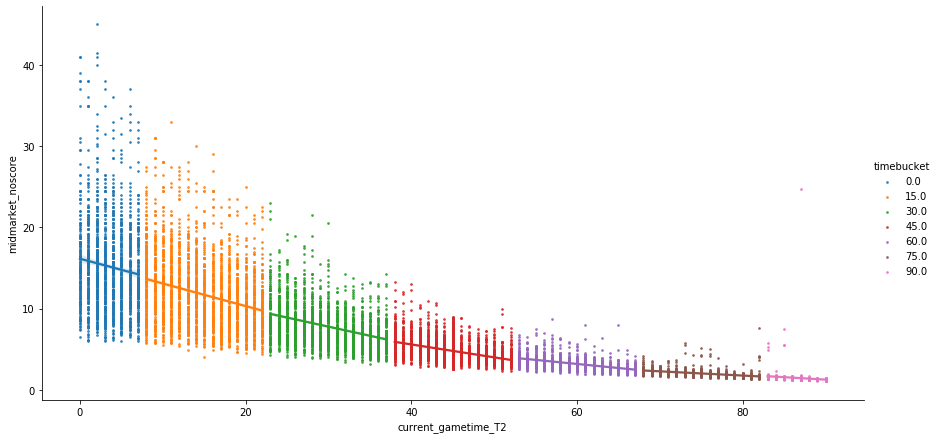

In [58]:
plt.figure(figsize=(12,6))
sns.lmplot(data=df_sub, x='current_gametime_T2', y= 'midmarket_noscore', hue='timebucket',
           scatter_kws = {'s':3}, aspect = 2, height=6)

## LMplot for all game categories

This already looks nice. We have run the regression on **all** 840 games. So could make an estimate of the midmarket_noscore for every current_gametime. 

But of course the **relationship is different per game category**. Below we will perform the same regression and create the LMplot for every category individually.

In [82]:
back_F_factor_order = df_sub['back_F_factor'].unique()[[0,1,3,2]]#.sort_values()

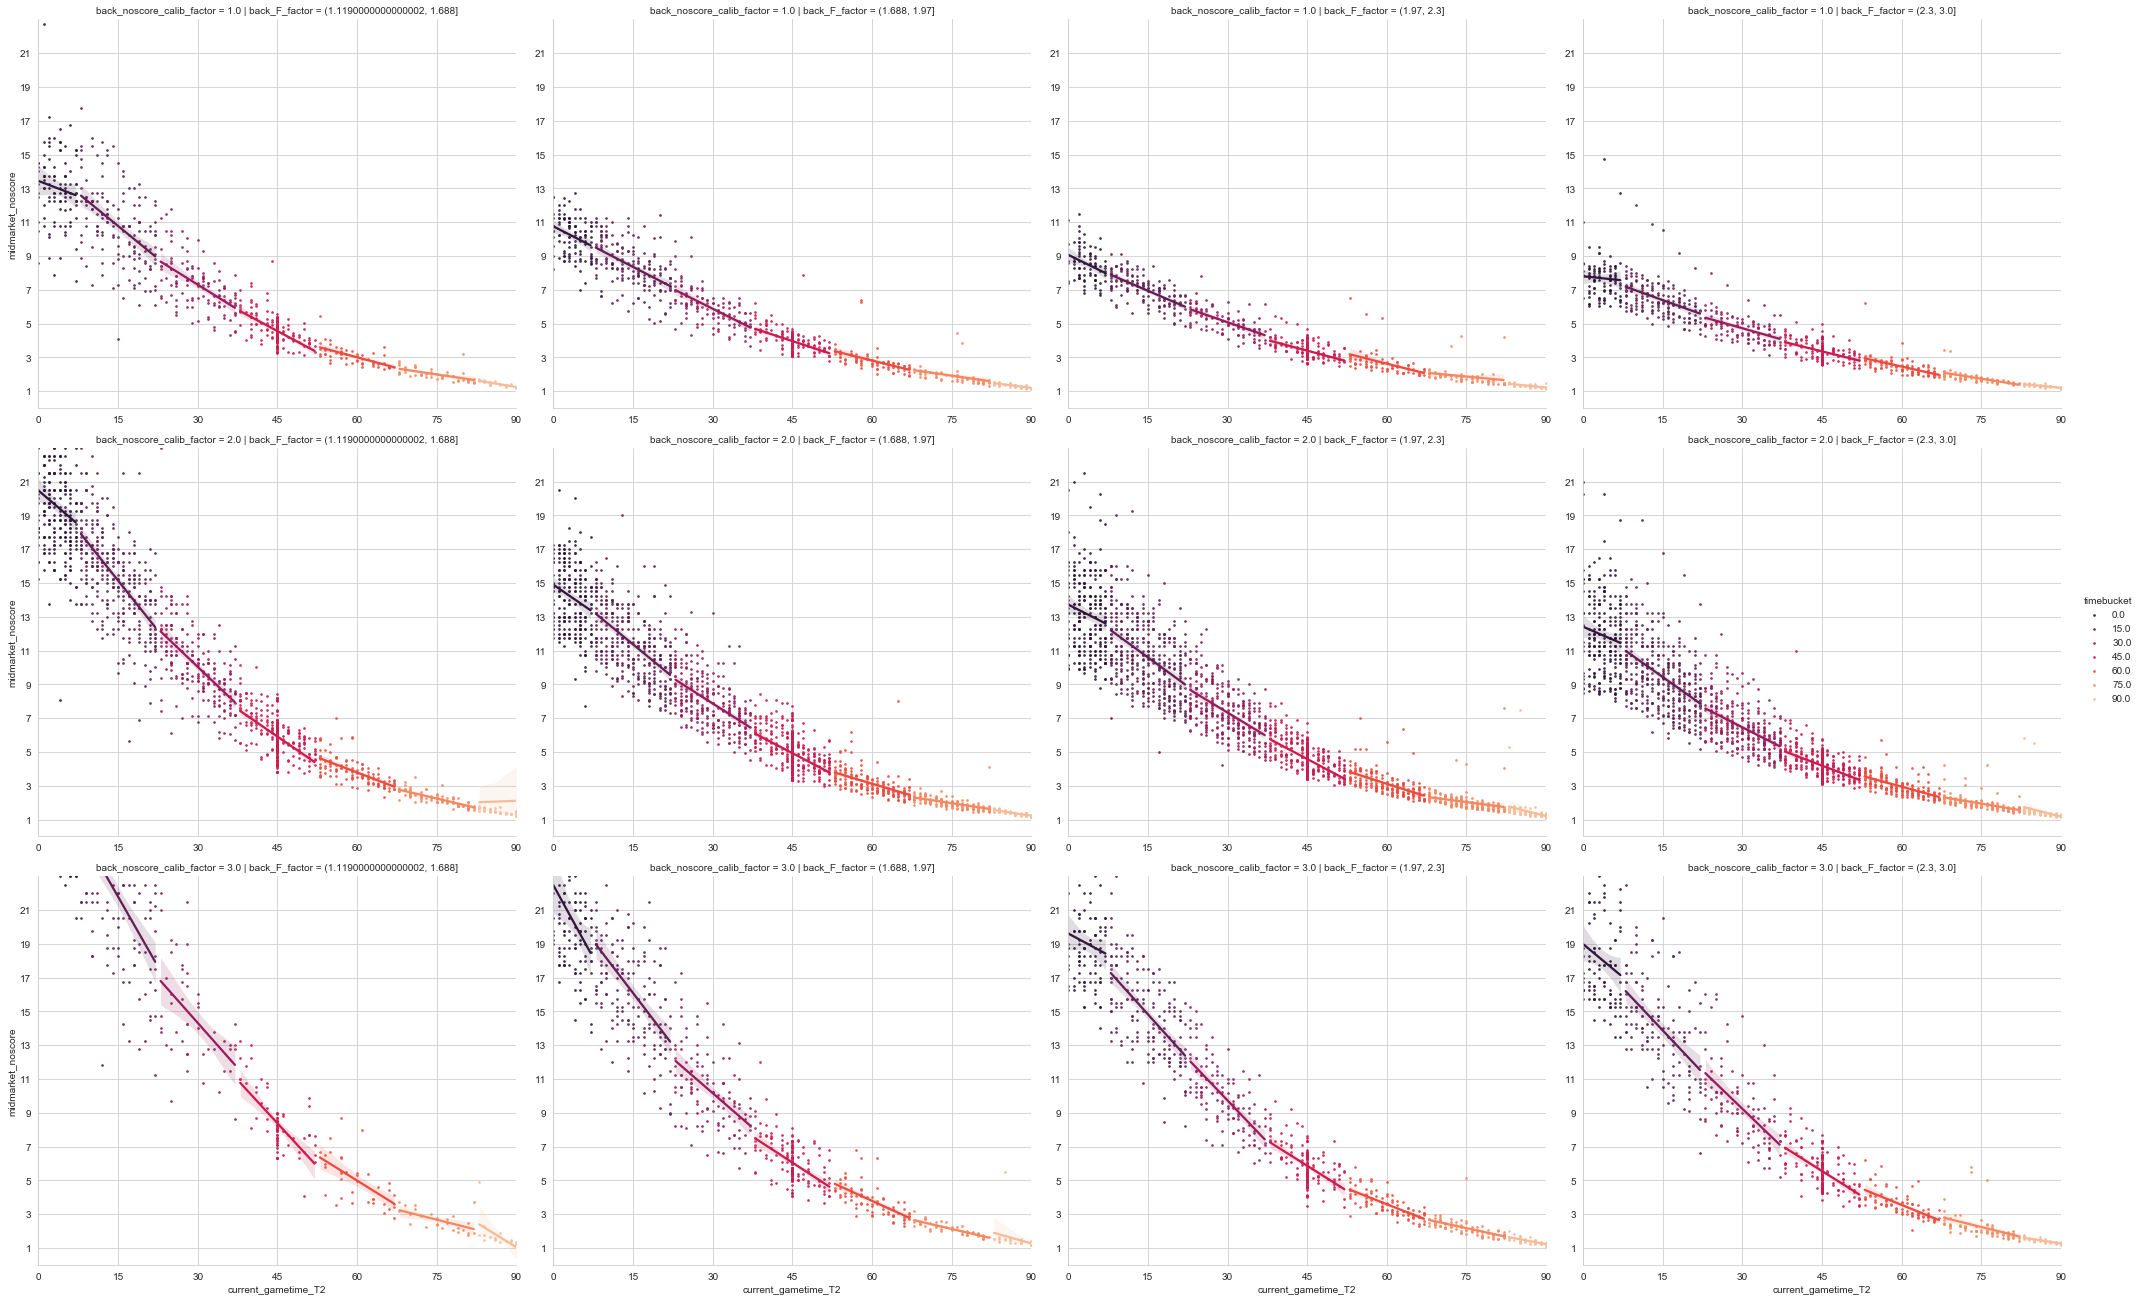

In [83]:
sns.set_style("whitegrid", {'axes.grid' : True})
g = sns.lmplot(data=df_sub, x='current_gametime_T2', y='midmarket_noscore', hue='timebucket', col='back_F_factor',
               row = 'back_noscore_calib_factor', scatter_kws = {'s':3}, aspect = 1.2, height=6, sharex=False, sharey=False,
              col_order = back_F_factor_order, palette="rocket")
g = (g.set(xlim=(0, 90), ylim=(0, 23),
           xticks=[0,15,30,45,60,75,90], yticks=np.arange(1,23,2)))

In [37]:
#g.savefig("./output/madmarket_noscore_estimates_timebuckets.png")

This looks better. The relationships are logical: higher midmarket_noscore at any T for higher scoring likelihood, etc. 

Of course simply the LMplot won't do. To actually get to the midmarket_noscores and noscore_probas we need to run an sklearn linear regression and use its predict function. Let's do this, starting with one game category: our lowest favourite and lowest scoring likelihood.

## Linear regression for 1 category

We will start by doing this for 1 category, being our 'F+, low scoring likelihood' games.

In [90]:
#filter out the desired game observations
df_sub2 = df[(df['back_F_factor'] == back_F_factor_order[3]) & (df['back_noscore_calib_factor'] == 1)
             & (df['market_name'] == 'Correct Score') & (df['current_gametime_T2'] >= 0)
              & (df['current_gametime_T2'] <= 90) & (df['score_diff_label'] == 'F+0') & (~df['midmarket_noscore'].isnull())]

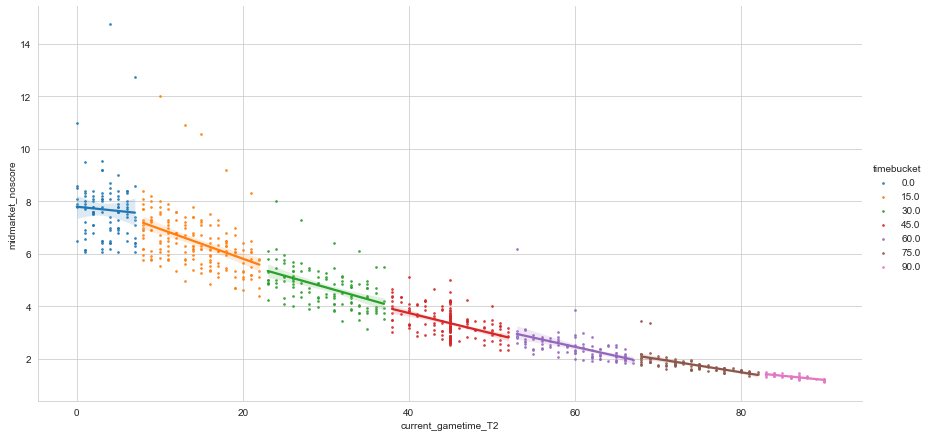

In [91]:
#lmplot for this category
sns.lmplot(data=df_sub2, x='current_gametime_T2', y='midmarket_noscore', hue = 'timebucket',
           scatter_kws = {'s':3}, aspect = 2, height=6)

In [86]:
from sklearn.linear_model import LinearRegression

In [92]:
estimates = pd.DataFrame(data=np.zeros((6,1)),index=starts,columns=['noscore_estimate'])

In [93]:
for t in starts:
    df_sub3 = df_sub2[df_sub2['timebucket'] == t]
    lm = LinearRegression()
    lm.fit(X=df_sub3['current_gametime_T2'].values.reshape(-1, 1), y=df_sub3['midmarket_noscore'])
    prediction = lm.predict(np.array(t).reshape(-1, 1))
    estimates.loc[t] = prediction

In [94]:
estimates.T

,0,15,30,45,60,75
noscore_estimate,7.795619,6.38186,4.719122,3.351575,2.452623,1.73307


In [95]:
#expected percentage of noscore games T= [15, 30, 45, 60, 75]
1 / estimates.T

,0,15,30,45,60,75
noscore_estimate,0.128277,0.156694,0.211904,0.298367,0.407727,0.577011


## All game categories

Make these noscore estimates for all the game categories.

In [96]:
starts = [0,15,30,45,60,75]
back_F_factor_order = df_sub['back_F_factor'].unique()[[0,1,3,2]]#.sort_values()
fav_cats = list(back_F_factor_order)
fav_cats.append('All')
noscore_cats = [1,2,3,'All']
estimates_table = pd.DataFrame(data=np.zeros((20,6)),index=[np.array(fav_cats).repeat(4), np.tile(np.array(noscore_cats),5)], 
                               columns=starts) #flat table to store results
estimates_table.index.names = ['back_F_factor', 'noscore_cat']

for fav_cat in fav_cats:
    for noscore_cat in noscore_cats:
        
        #get the relevant gametags
        if ((fav_cat == 'All') & (noscore_cat == 'All')):
            gametags = df[df['mins15'] == 0]['gametag'].unique()
        elif (fav_cat == 'All'):
            gametags = df[(df['mins15'] == 0) & (df['back_noscore_calib_factor'] == noscore_cat)]['gametag'].unique()
        elif (noscore_cat == 'All'):
            gametags = df[(df['mins15'] == 0) & (df['back_F_factor'] == fav_cat)]['gametag'].unique()
        else:
            gametags = df[(df['mins15'] == 0) & (df['back_F_factor'] == fav_cat) 
                         & (df['back_noscore_calib_factor'] == noscore_cat)]['gametag'].unique()
        
        #get the desired game observations
        df_sub2 = df[(df['gametag'].isin(gametags)) & (df['market_name'] == 'Correct Score') & (df['current_gametime_T2'] >= 0)
              & (df['current_gametime_T2'] <= 90) & (df['score_diff_label'] == 'F+0') & (~df['midmarket_noscore'].isnull())]
        
        #fit the model for every t
        for t in starts:
            df_sub3 = df_sub2[df_sub2['timebucket'] == t]
            lm = LinearRegression()
            lm.fit(X=df_sub3['current_gametime_T2'].values.reshape(-1, 1), y=df_sub3['midmarket_noscore'])
            estimate = lm.predict(np.array(t).reshape(-1, 1))
            
            #store the estimate
            estimates_table.loc[(fav_cat, str(noscore_cat)),t] = estimate

estimates_table.reset_index(drop=False,inplace=True)

In [97]:
estimates_table

,back_F_factor,noscore_cat,0,15,30,45,60,75
0,"(1.1190000000000002, 1.688]",1,13.439958,10.772551,7.299465,4.556605,3.002987,1.989028
1,"(1.1190000000000002, 1.688]",2,20.470333,15.140592,10.034415,5.911974,3.786524,2.243909
2,"(1.1190000000000002, 1.688]",3,32.236097,21.785178,14.318165,8.381557,4.987100,2.671064
3,"(1.1190000000000002, 1.688]",All,21.558577,15.374701,9.732754,5.813715,3.778378,2.236104
4,"(1.688, 1.97]",1,10.748893,8.351375,5.877244,3.962633,2.813250,1.915105
5,"(1.688, 1.97]",2,14.896072,11.367619,7.869178,4.931968,3.122463,1.967221
6,"(1.688, 1.97]",3,22.466309,16.086856,10.162006,6.054394,3.788903,2.123576
7,"(1.688, 1.97]",All,15.526455,11.727845,7.914137,4.941041,3.191294,1.984341
8,"(1.97, 2.3]",1,9.063885,6.937812,5.075369,3.395149,2.624523,1.861464
9,"(1.97, 2.3]",2,13.720348,10.596082,7.326680,4.581075,3.112810,2.032310


In [98]:
#transform the flat table to a list of dataframes
d1 = pd.DataFrame(np.zeros((5,4)), index = fav_cats, columns = [1,2,3,'All'])
midmarket_noscore_estimates = [d1,d1,d1,d1,d1,d1] #list of 6 empty dataframes

for (nr,start) in enumerate(starts):
    d1 = estimates_table[['back_F_factor','noscore_cat',start]].pivot_table(index='back_F_factor',columns='noscore_cat')
    d1.columns = [1,2,3,'All']
    midmarket_noscore_estimates[nr] = d1

In [99]:
#Estimates for T=15
midmarket_noscore_estimates[2]

,1,2,3,All
back_F_factor,,,,
"(1.1190000000000002, 1.688]",7.299465,10.034415,14.318165,9.732754
"(1.688, 1.97]",5.877244,7.869178,10.162006,7.914137
"(1.97, 2.3]",5.075369,7.326680,9.726702,7.430568
"(2.3, 3.0]",4.719122,6.454682,9.227471,6.628209
All,5.761215,7.755656,10.274416,7.791349


Now we have midmarket_noscore estimates for all game categories at all LTD_starts. Victory!

The estimate for T=0 can be overwritten with the mean back_noscore_calib per category:

In [100]:
st = strat_1_tables[0]
midmarket_noscore_estimates[0] = st.pivot_table(values='back_noscore_calib',index='back_F_factor', 
                                           columns='back_noscore_calib_factor', aggfunc='mean',margins=True)

## Expected and actual noscore games

Now we have the estimated midmarket noscore quotes, we can easily derive the expected percentage and number of noscore games per category:

In [101]:
#expected percentage of noscore games for all Ts
exp_noscore_perc = [1 / x for x in midmarket_noscore_estimates]

In [102]:
exp_noscore_perc[1]

,1,2,3,All
back_F_factor,,,,
"(1.1190000000000002, 1.688]",0.092829,0.066048,0.045903,0.065042
"(1.688, 1.97]",0.119741,0.087969,0.062163,0.085267
"(1.97, 2.3]",0.144138,0.094375,0.067459,0.092462
"(2.3, 3.0]",0.156694,0.106077,0.072119,0.105158
All,0.123669,0.087139,0.060857,0.085242


In [103]:
#count of expected noscore games for all Ts
exp_noscore_counts = exp_noscore_perc.copy()
for i in range(0,len(exp_noscore_perc)):
    exp_noscore_perc[i].index = strat_1_count_pivots[i].index #make indices equal
    exp_noscore_counts[i] = strat_1_count_pivots[i] * exp_noscore_perc[i] #element by element multiplication

In [119]:
midmarket_noscore_estimates[0]

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.1190000000000002, 1.688]",12.510455,19.172414,32.880000,21.040286
"(1.688, 1.97]",9.620000,13.959091,20.566038,14.584507
"(1.97, 2.3]",8.240909,12.930833,19.010638,13.307109
"(2.3, 3.0]",7.141304,11.607143,18.010417,12.101942
All,9.361739,14.434934,22.686869,15.268762


In [105]:
exp_noscore_perc[2]

,1,2,3,All
back_F_factor,,,,
"(1.179, 1.86]",0.136996,0.099657,0.069841,0.102746
"(1.86, 2.13]",0.170148,0.127078,0.098406,0.126356
"(2.13, 2.46]",0.197030,0.136487,0.102810,0.134579
"(2.46, 3.15]",0.211904,0.154926,0.108372,0.150870
All,0.173575,0.128938,0.097329,0.128347


In [121]:
strat_1_count_pivots[0]

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.1190000000000002, 1.688]",44.0,116.0,50.0,210.0
"(1.688, 1.97]",50.0,110.0,53.0,213.0
"(1.97, 2.3]",44.0,120.0,47.0,211.0
"(2.3, 3.0]",46.0,112.0,48.0,206.0
All,184.0,458.0,198.0,840.0


In [107]:
25/4.719122

5.297595612065126

In [120]:
exp_noscore_counts[0]

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.1190000000000002, 1.688]",3.517058,6.050360,1.520681,9.980853
"(1.688, 1.97]",5.197505,7.880169,2.577064,14.604539
"(1.97, 2.3]",5.339217,9.280144,2.472300,15.856186
"(2.3, 3.0]",6.441400,9.649231,2.665124,17.022062
All,19.654468,31.728582,8.727516,55.014284


### Actual number of noscore games in our sample, for all game categories

In [109]:
#count of actual noscore games for all Ts
actual_noscore_counts = [st.pivot_table(values='noscore_game',index='back_F_factor', columns='back_noscore_calib_factor',
                                       aggfunc=sum,margins=True) for st in strat_2_tables]

In [110]:
actual_noscore_counts[0]

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.1190000000000002, 1.688]",3.0,1.0,2.0,6.0
"(1.688, 1.97]",7.0,5.0,3.0,15.0
"(1.97, 2.3]",5.0,14.0,4.0,23.0
"(2.3, 3.0]",2.0,9.0,3.0,14.0
All,17.0,29.0,12.0,58.0


## Delta and profit correction for all categories over all Ts

Now we have the actual number of noscore games, and the expected number of noscore games, we can:
- calculate the difference
- correct the net profits, both sum and mean, for both strategies

In [111]:
#initialisation of new lists of dataframes
actual_exp_noscore_diffs = actual_noscore_counts.copy()
strat_1_sum_pivots_corrected = strat_1_sum_pivots.copy()
strat_2_sum_pivots_corrected = strat_2_sum_pivots.copy()
strat_1_mean_pivots_corrected = strat_1_mean_pivots.copy()
strat_2_mean_pivots_corrected = strat_2_mean_pivots.copy()

In [112]:
#calculate the noscore_diffs and corrected profits, and fill the dataframes
for i in range(0,len(actual_noscore_counts)):
    actual_exp_noscore_diffs[i] = actual_noscore_counts[i] - exp_noscore_counts[i]
    strat_1_sum_pivots_corrected[i] = strat_1_sum_pivots[i] + actual_exp_noscore_diffs[i]
    strat_2_sum_pivots_corrected[i] = strat_2_sum_pivots[i] + actual_exp_noscore_diffs[i]
    strat_1_mean_pivots_corrected[i] = (strat_1_sum_pivots_corrected[i] / strat_1_count_pivots[i])
    strat_2_mean_pivots_corrected[i] = (strat_2_sum_pivots_corrected[i] / strat_2_count_pivots[i])

Now we have new results! Time to visualize them in relation to the old results

In [129]:
strat_1_sum_pivots_corrected[4]

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.189, 2.34]",-1.642834,-1.099945,-0.069235,-2.887638
"(2.34, 2.69]",-1.139122,-2.420056,0.015162,-3.335497
"(2.69, 3.1]",1.484651,-1.385685,-1.000990,-0.552140
"(3.1, 4.2]",1.572175,-2.766696,-0.699184,-1.722131
All,0.040860,-8.132484,-2.368336,-9.647250


# Visualizations: sample vs corrected results, per game category

### Strategy 1

In [114]:
#we need to create a flat file in preparation for making the catplot
results_all_flat = pd.DataFrame(columns=['fav_cat','scoring_likelihood','net_profit','LTD_start','correction'])
correction = ['sample_data', 'corrected']

for (nr,i) in enumerate([strat_1_mean_pivots, strat_1_mean_pivots_corrected]):
    for j in np.arange(0,6,1):
        x = pd.DataFrame(i[j].drop('All').drop('All',axis=1))
        x.index = ['F++++','F+++','F++','F+']
        x.reset_index(drop=False,inplace=True)
        x = x.melt(id_vars=["index"], var_name="scoring_likelihood", value_name="net_profit")
        x.columns = ['fav_cat','scoring_likelihood','net_profit']
        x['LTD_start'] = starts[j]
        x['correction'] = correction[nr]
        results_all_flat = results_all_flat.append(x,ignore_index=True)

In [115]:
results_all_flat.head(3)

,fav_cat,scoring_likelihood,net_profit,LTD_start,correction
0,F++++,1,-0.032504,0,sample_data
1,F+++,1,-0.104510,0,sample_data
2,F++,1,-0.037321,0,sample_data


<Figure size 936x720 with 0 Axes>

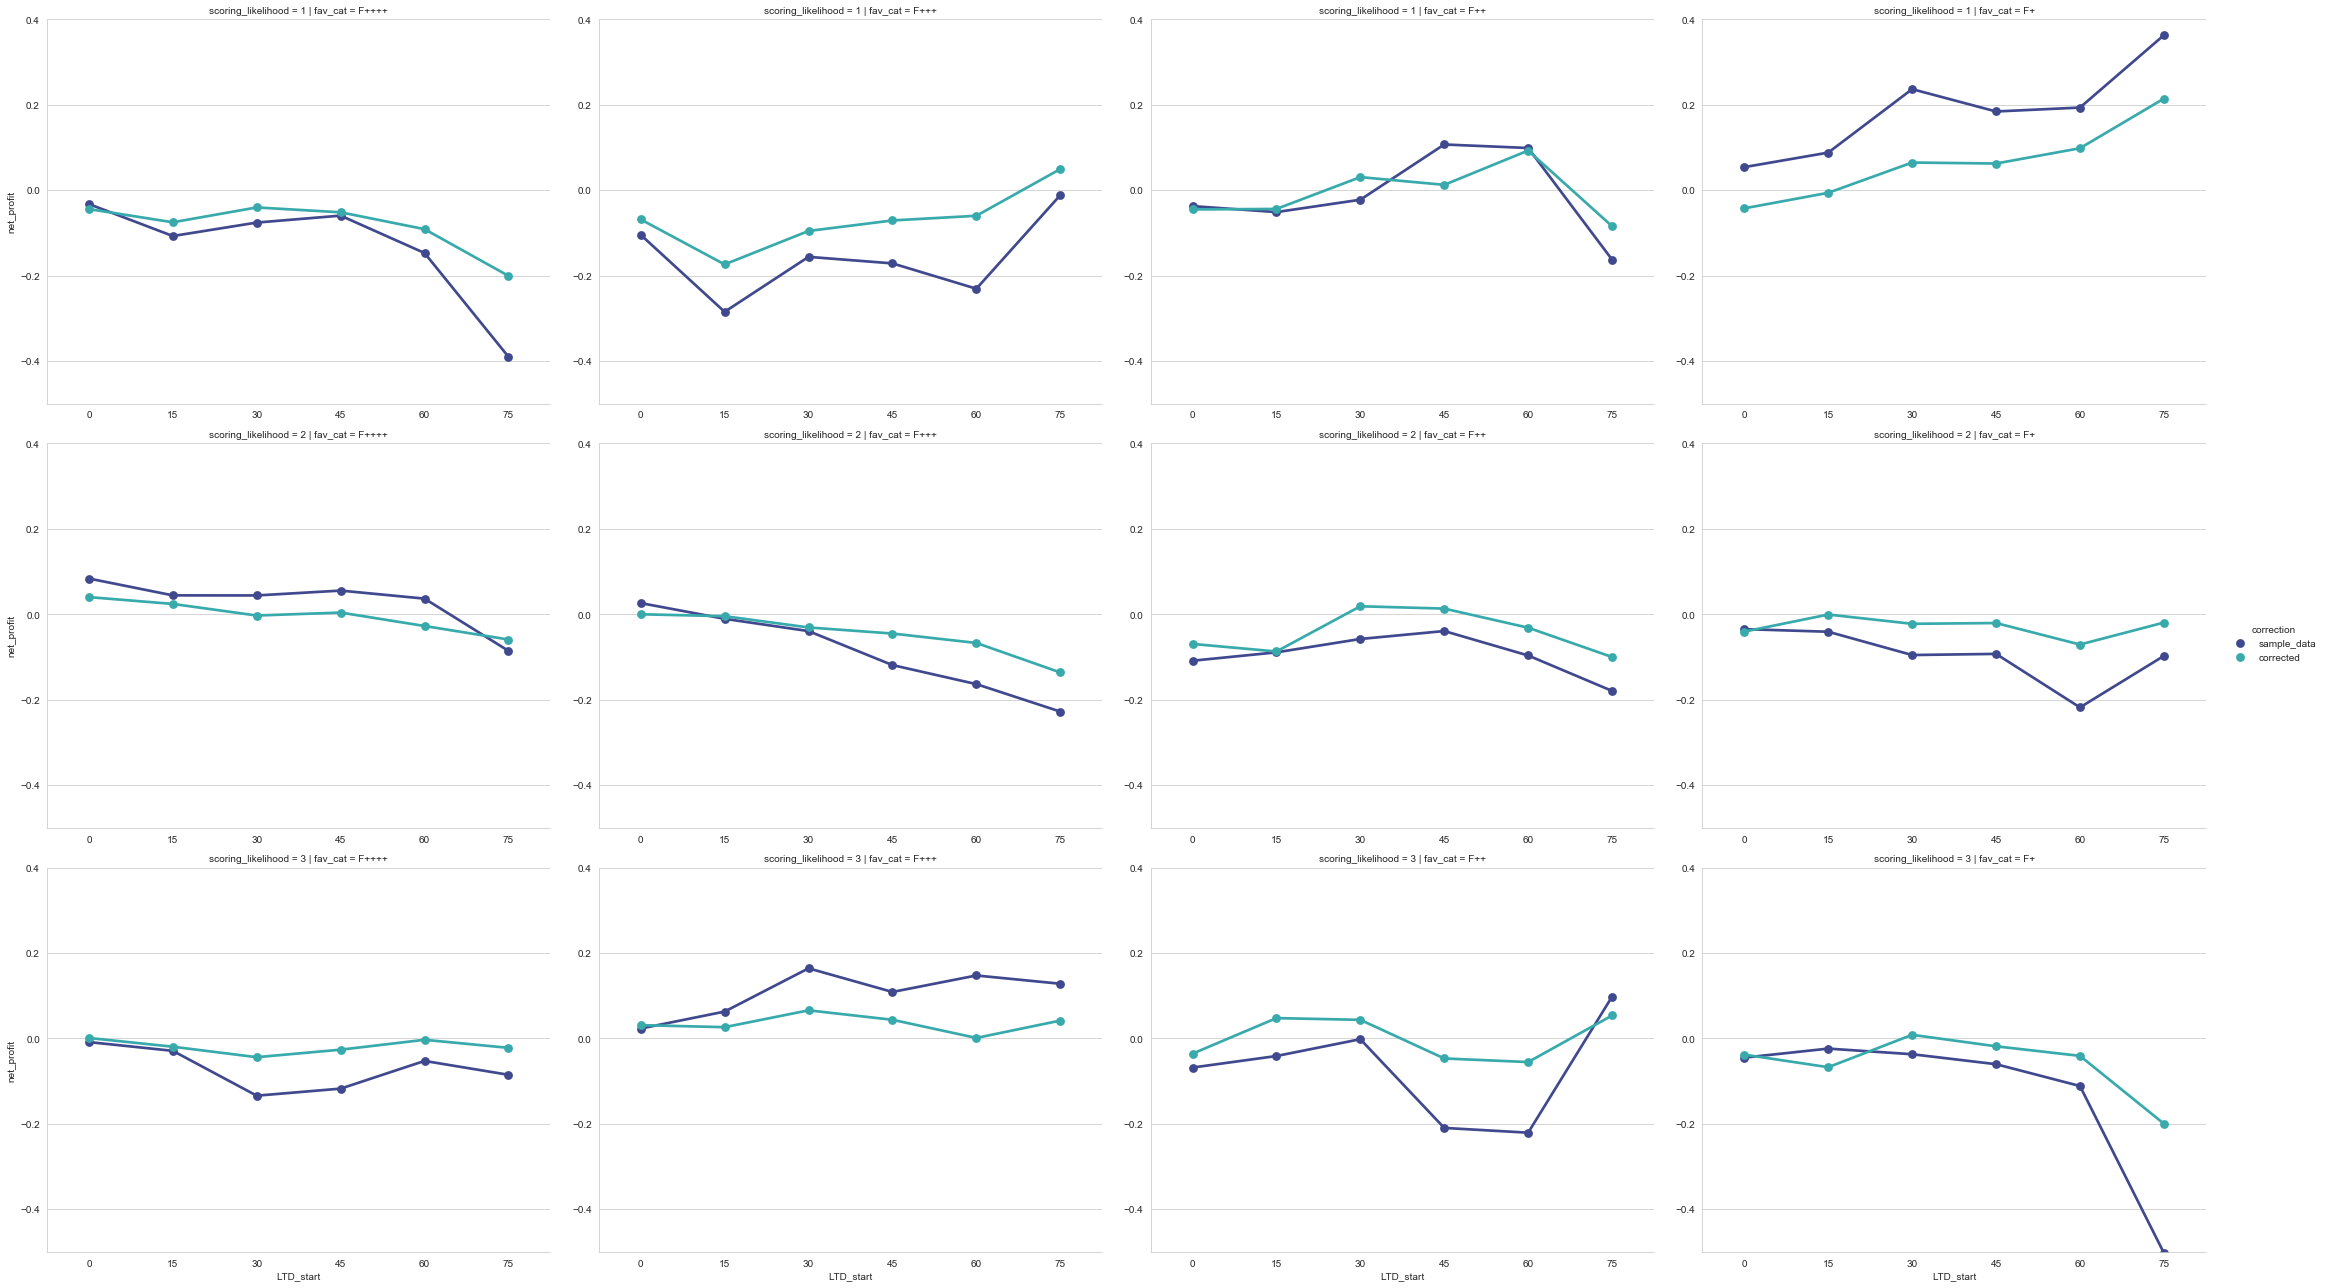

In [65]:
sns.set_style("whitegrid", {'axes.grid' : True})
plt.figure(figsize = (13,10))
g = sns.catplot(x="LTD_start", y="net_profit", hue="correction", row="scoring_likelihood", col="fav_cat",
                capsize=.2, height=6, aspect=1.3, sharex=False, sharey=False, palette="mako",
                kind="point", data=results_all_flat)
g = (g.set(ylim=(-0.5, 0.4), yticks=np.arange(-0.4,0.6,0.2)))

<Figure size 936x720 with 0 Axes>

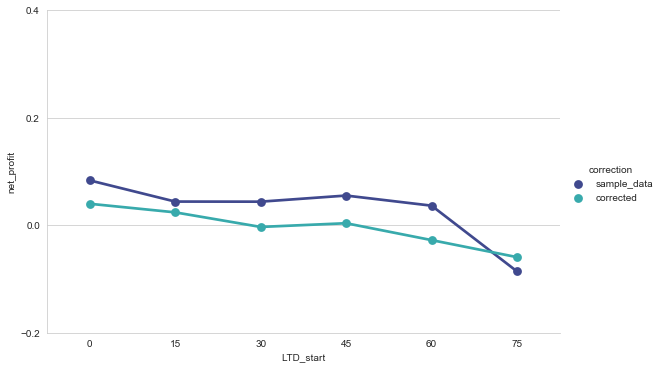

In [127]:
subset = results_all_flat[(results_all_flat['fav_cat'] == 'F++++') & (results_all_flat['scoring_likelihood'] == 2)]
sns.set_style("whitegrid", {'axes.grid' : True})
plt.figure(figsize = (13,10))
g = sns.catplot(x="LTD_start", y="net_profit", hue="correction",
                capsize=.2, height=5, aspect=1.6, sharex=False, sharey=False, palette="mako",
                kind="point", data=subset)
g = (g.set(ylim=(-0.2, 0.4), yticks=np.arange(-0.2,0.6,0.2)))

### Conclusions

Unfortuntately the main conclusions are that:
- the net profits of our selected 'winning LTD categories' (F+/low-SL/T30, F++/low-SL/T45, F+++/high-SL/T30, F+++/medium-SL/T0, F++++/medium-SL/T0) are **all corrected downwards** after taking into account the under-representation of noscore games for these categories in our sample
- the categories that get an upwards correction for over-representation of noscore games still stay below or around net profits of 0, meaning that **no new categories arise** as potential 'winning LTD categories'

All together this means that with these new insights, we can conclude that **standard playing of the LTD strategy will not lead to big profits** in any of the game categories. However small profits can still be found in the following categories:
- F+/low-SL/T30: 1.62 from 25 games, 6.47%
- F++/low-SL/T60: 1.48 from 16 games, 9.3% (but big loss at T75)

In [66]:
#g.savefig("./output/net_profits_strategy_1_sample_vs_corrected.png")

### Strategy 2

Earlier we already concluded that there is no significant difference between the net profits for strategy 1 and strategy 2, but for completeness we will also create the comparative graph for strategy 2.

In [67]:
results_all_flat = pd.DataFrame(columns=['fav_cat','scoring_likelihood','net_profit','LTD_start','correction'])
correction = ['sample_data', 'corrected']

for (nr,i) in enumerate([strat_2_mean_pivots, strat_2_mean_pivots_corrected]):
    for j in np.arange(0,6,1):
        x = pd.DataFrame(i[j].drop('All').drop('All',axis=1))
        x.index = ['F++++','F+++','F++','F+']
        x.reset_index(drop=False,inplace=True)
        x = x.melt(id_vars=["index"], var_name="scoring_likelihood", value_name="net_profit")
        x.columns = ['fav_cat','scoring_likelihood','net_profit']
        x['LTD_start'] = starts[j]
        x['correction'] = correction[nr]
        results_all_flat = results_all_flat.append(x,ignore_index=True)

In [68]:
results_all_flat.head(3)

,fav_cat,scoring_likelihood,net_profit,LTD_start,correction
0,F++++,1,-0.044024,0,sample_data
1,F+++,1,-0.104583,0,sample_data
2,F++,1,-0.022190,0,sample_data


<Figure size 936x720 with 0 Axes>

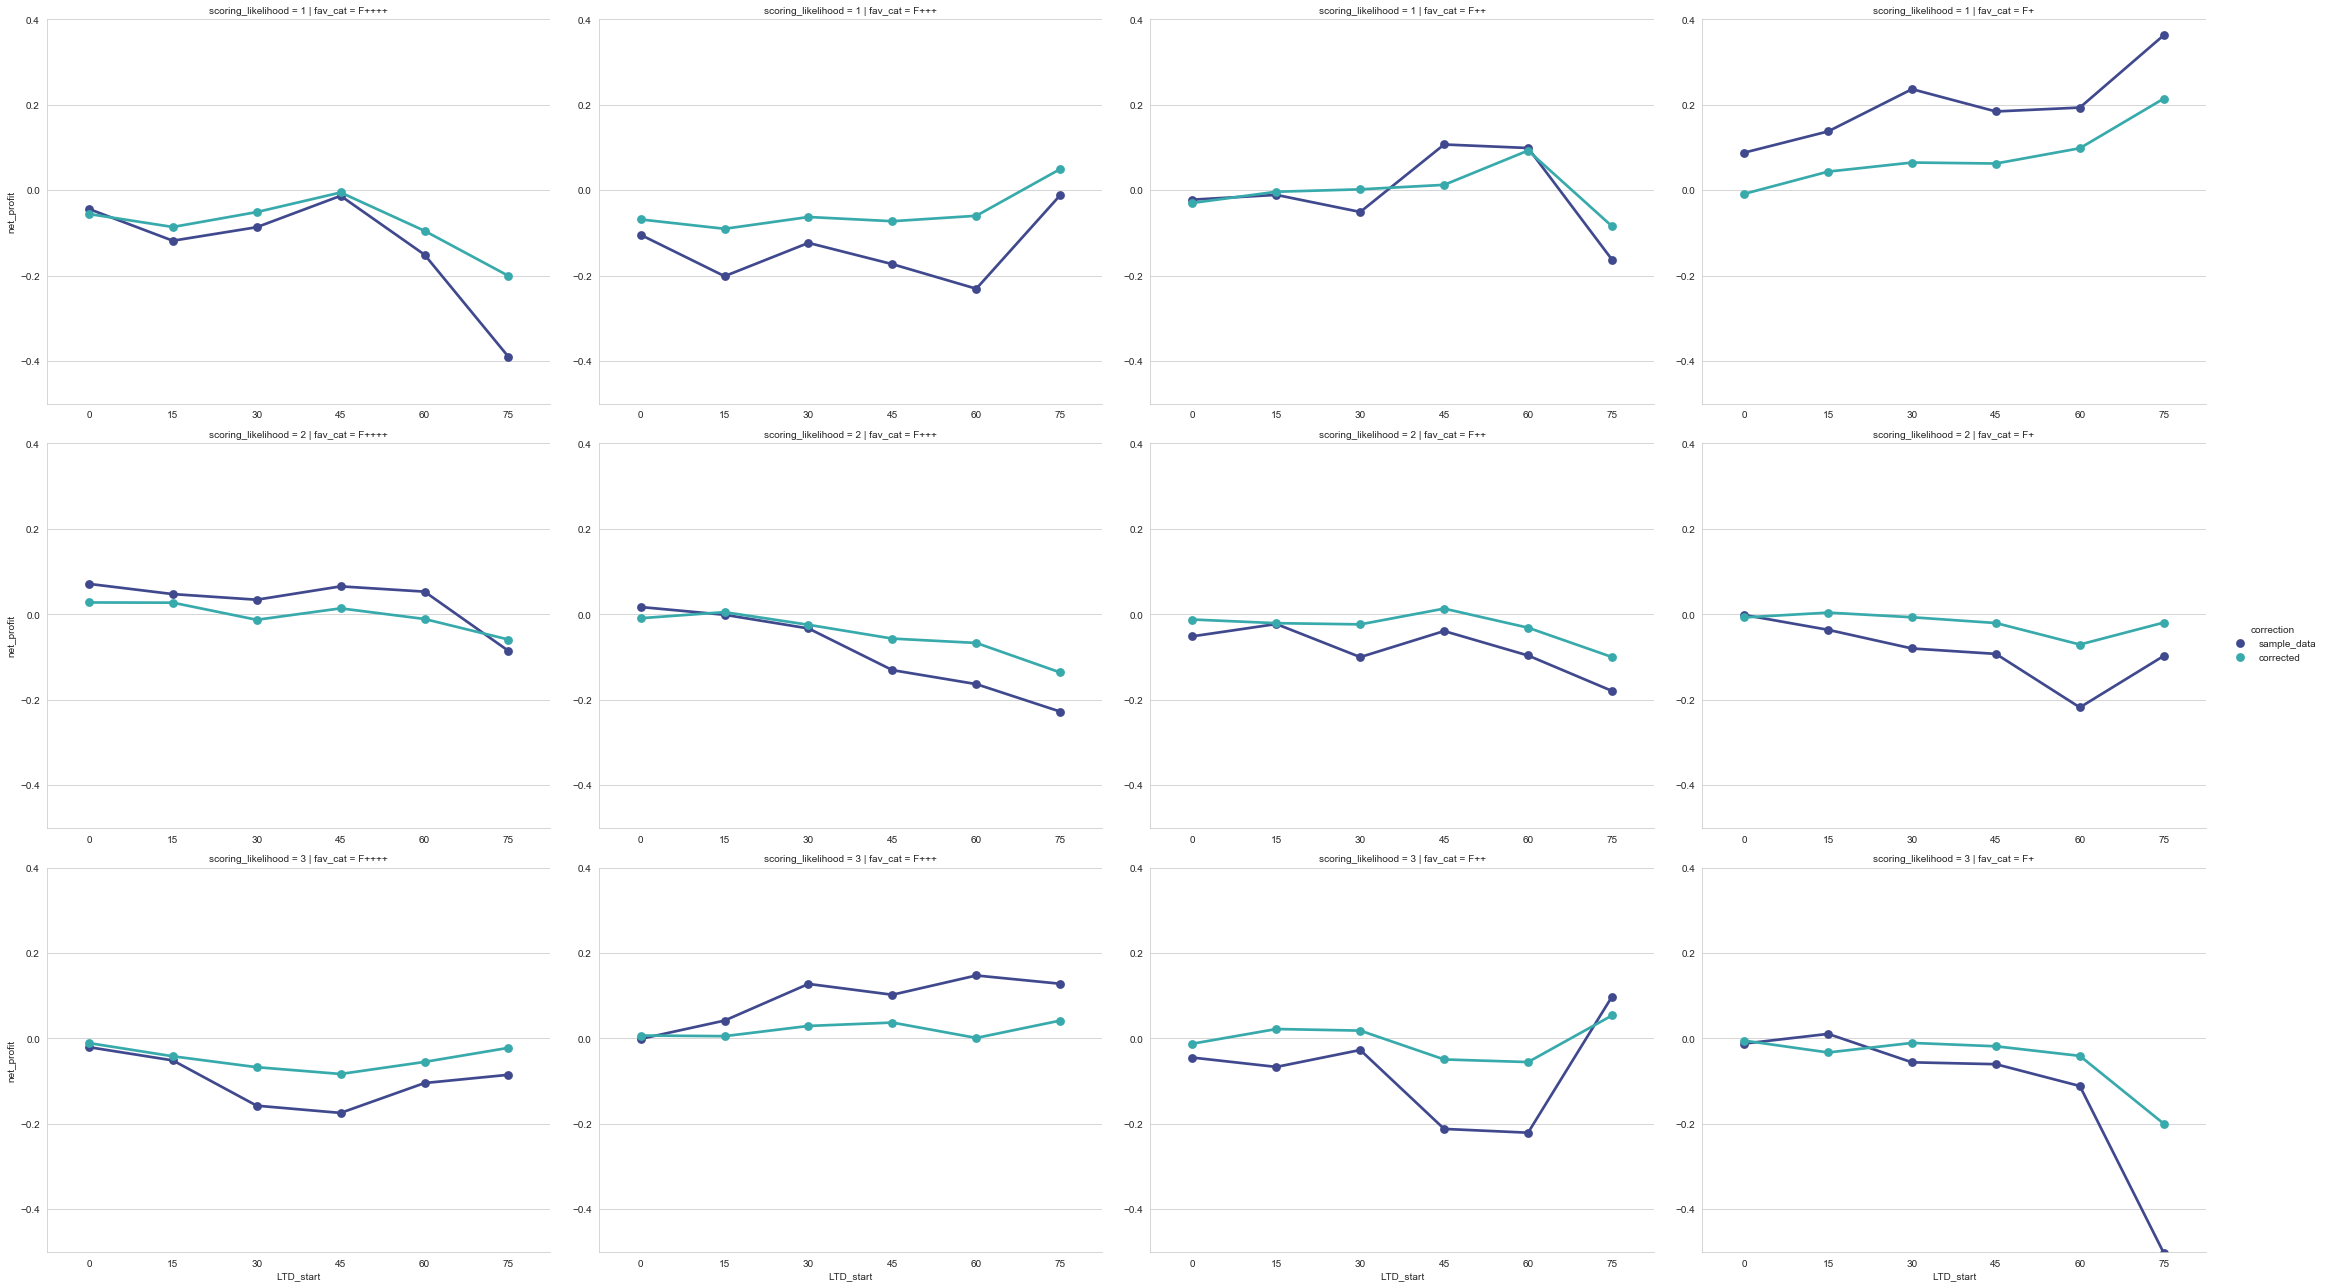

In [69]:
sns.set_style("whitegrid", {'axes.grid' : True})
plt.figure(figsize = (13,10))
g = sns.catplot(x="LTD_start", y="net_profit", hue="correction", row="scoring_likelihood", col="fav_cat",
                capsize=.2, height=6, aspect=1.3, sharex=False, sharey=False, palette="mako",
                kind="point", data=results_all_flat)
g = (g.set(ylim=(-0.5, 0.4), yticks=np.arange(-0.4,0.6,0.2)))

In [70]:
#g.savefig("./output/net_profits_strategy_2_sample_vs_corrected.png")

# Visualizations: back_X over time

Above we have nicely plotted the relationship between midmarket_noscore and game time. It would also be useful to get this insight for the back_X/lay_X (maybe also midmarket_X), especially for the categories we would play. This way we can get an insight in what is a high and what is a low back_X quote, at each gametime.

We still have the attribute timebucket in our dataframe:

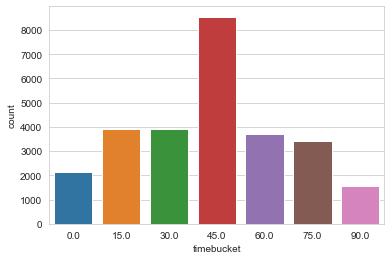

In [71]:
sns.countplot(df[(df['market_name'] == 'Match Odds') & (df['current_gametime_T2'] >=0) 
               & (df['current_gametime_T2'] <=90)]['timebucket'])

And we also still have the game categories in our df.

We can create the midmarket_X just like we did for midmarket_noscore:

In [73]:
#new attribute for the whole df: midmarket_noscore
df['midmarket_X'] = (df['back_X'] + df['lay_X'])/2

And exclude the outliers:

In [87]:
#calculate the 99% upper quantile so we can exclude outliers in the next step
quantiles = pd.DataFrame(data=np.zeros((91,1)), index = np.arange(0,91,1), columns = ['midmarket_X_q99'])
df_sub = df[(df['market_name'] == 'Match Odds') & (df['current_gametime_T2'] >= 0)
          & (df['current_gametime_T2'] <= 90) & (df['score_diff_label'] == 'F+0')]
for gametime in quantiles.index:
    quantiles.iloc[gametime,0] = df_sub[df_sub['current_gametime_T2'] == gametime]['midmarket_X'].quantile(0.99)
quantiles.reset_index(drop=False,inplace=True)
quantiles.columns = ['current_gametime_T2','midmarket_X_q99']
quantiles['market_name'] = 'Match Odds'

df = df.merge(quantiles,how='left',on=['market_name','current_gametime_T2'])

In [88]:
#exclude outliers
df.loc[((df['midmarket_X'] >= 100) | (df['midmarket_X'] >= df['midmarket_X_q99'])), 'midmarket_X'] = np.nan

In [89]:
#filter out the desired game observations for our regression
df_sub = df[(df['market_name'] == 'Match Odds') & (df['current_gametime_T2'] >= 0)
          & (df['current_gametime_T2'] <= 90) & (df['score_diff_label'] == 'F+0') & (~df['midmarket_X'].isnull())]
df_sub[['gametag','market_name','current_gametime_T2','back_noscore_calib','back_X','lay_X','midmarket_X']].head()

,gametag,market_name,current_gametime_T2,back_noscore_calib,back_X,lay_X,midmarket_X
94,20190401_ARSNEW,Match Odds,0.0,21.0,4.9,5.0,4.95
98,20190401_ARSNEW,Match Odds,2.0,21.0,5.0,5.1,5.05
101,20190401_ARSNEW,Match Odds,4.0,21.0,5.1,5.2,5.15
104,20190401_ARSNEW,Match Odds,7.0,21.0,5.1,5.2,5.15
107,20190401_ARSNEW,Match Odds,9.0,21.0,4.7,4.8,4.75


<Figure size 864x432 with 0 Axes>

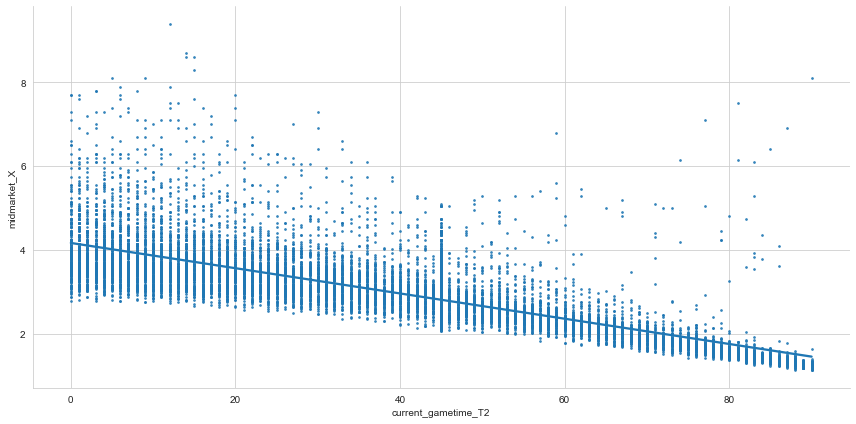

In [91]:
#plot for all games
plt.figure(figsize=(12,6))
sns.lmplot(data=df_sub, x='current_gametime_T2', y= 'midmarket_X', scatter_kws = {'s':3}, aspect = 2, height=6)

Again we see that the true relationship is not completely linear, but slightly regressive. Although a bit less than the noscore quote. Still we will perform the regression in timebuckets to get a more accurate picture.

<Figure size 864x432 with 0 Axes>

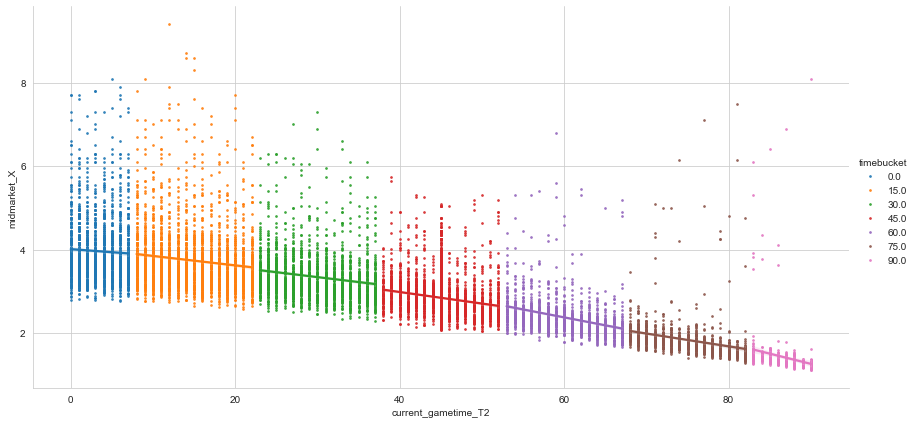

In [92]:
#plot for all games, in time buckets
plt.figure(figsize=(12,6))
sns.lmplot(data=df_sub, x='current_gametime_T2', y= 'midmarket_X', hue = 'timebucket', 
           scatter_kws = {'s':3}, aspect = 2, height=6)

Over all games it looks like a slightly progressive decline actually. Let's see if we get the same trend for a single category.

### F+ / low-SL

In [102]:
#filter out the desired game observations
df_sub2 = df_sub[(df_sub['back_F_factor'] == back_F_factor_order[3]) & (df_sub['back_noscore_calib_factor'] == 1)]

<Figure size 864x432 with 0 Axes>

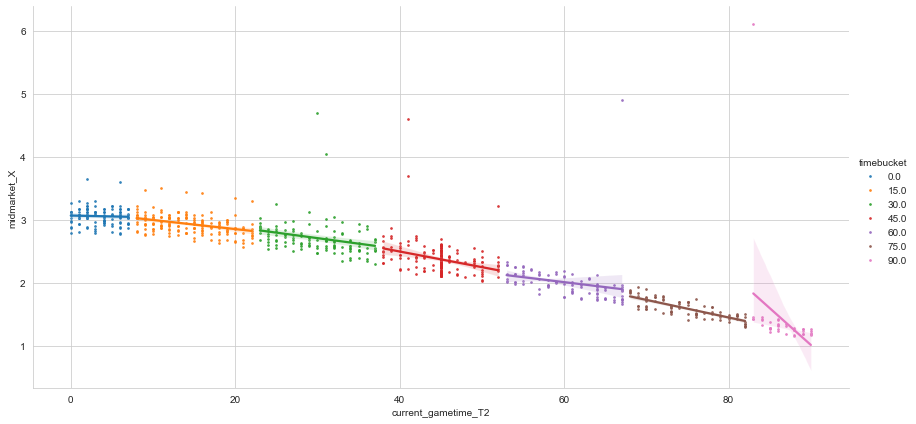

In [108]:
plt.figure(figsize=(12,6))
sns.lmplot(data=df_sub2, x='current_gametime_T2', y= 'midmarket_X', hue = 'timebucket', 
           scatter_kws = {'s':3}, aspect = 2, height=6)

Slightly progressive indeed.

### All game categories

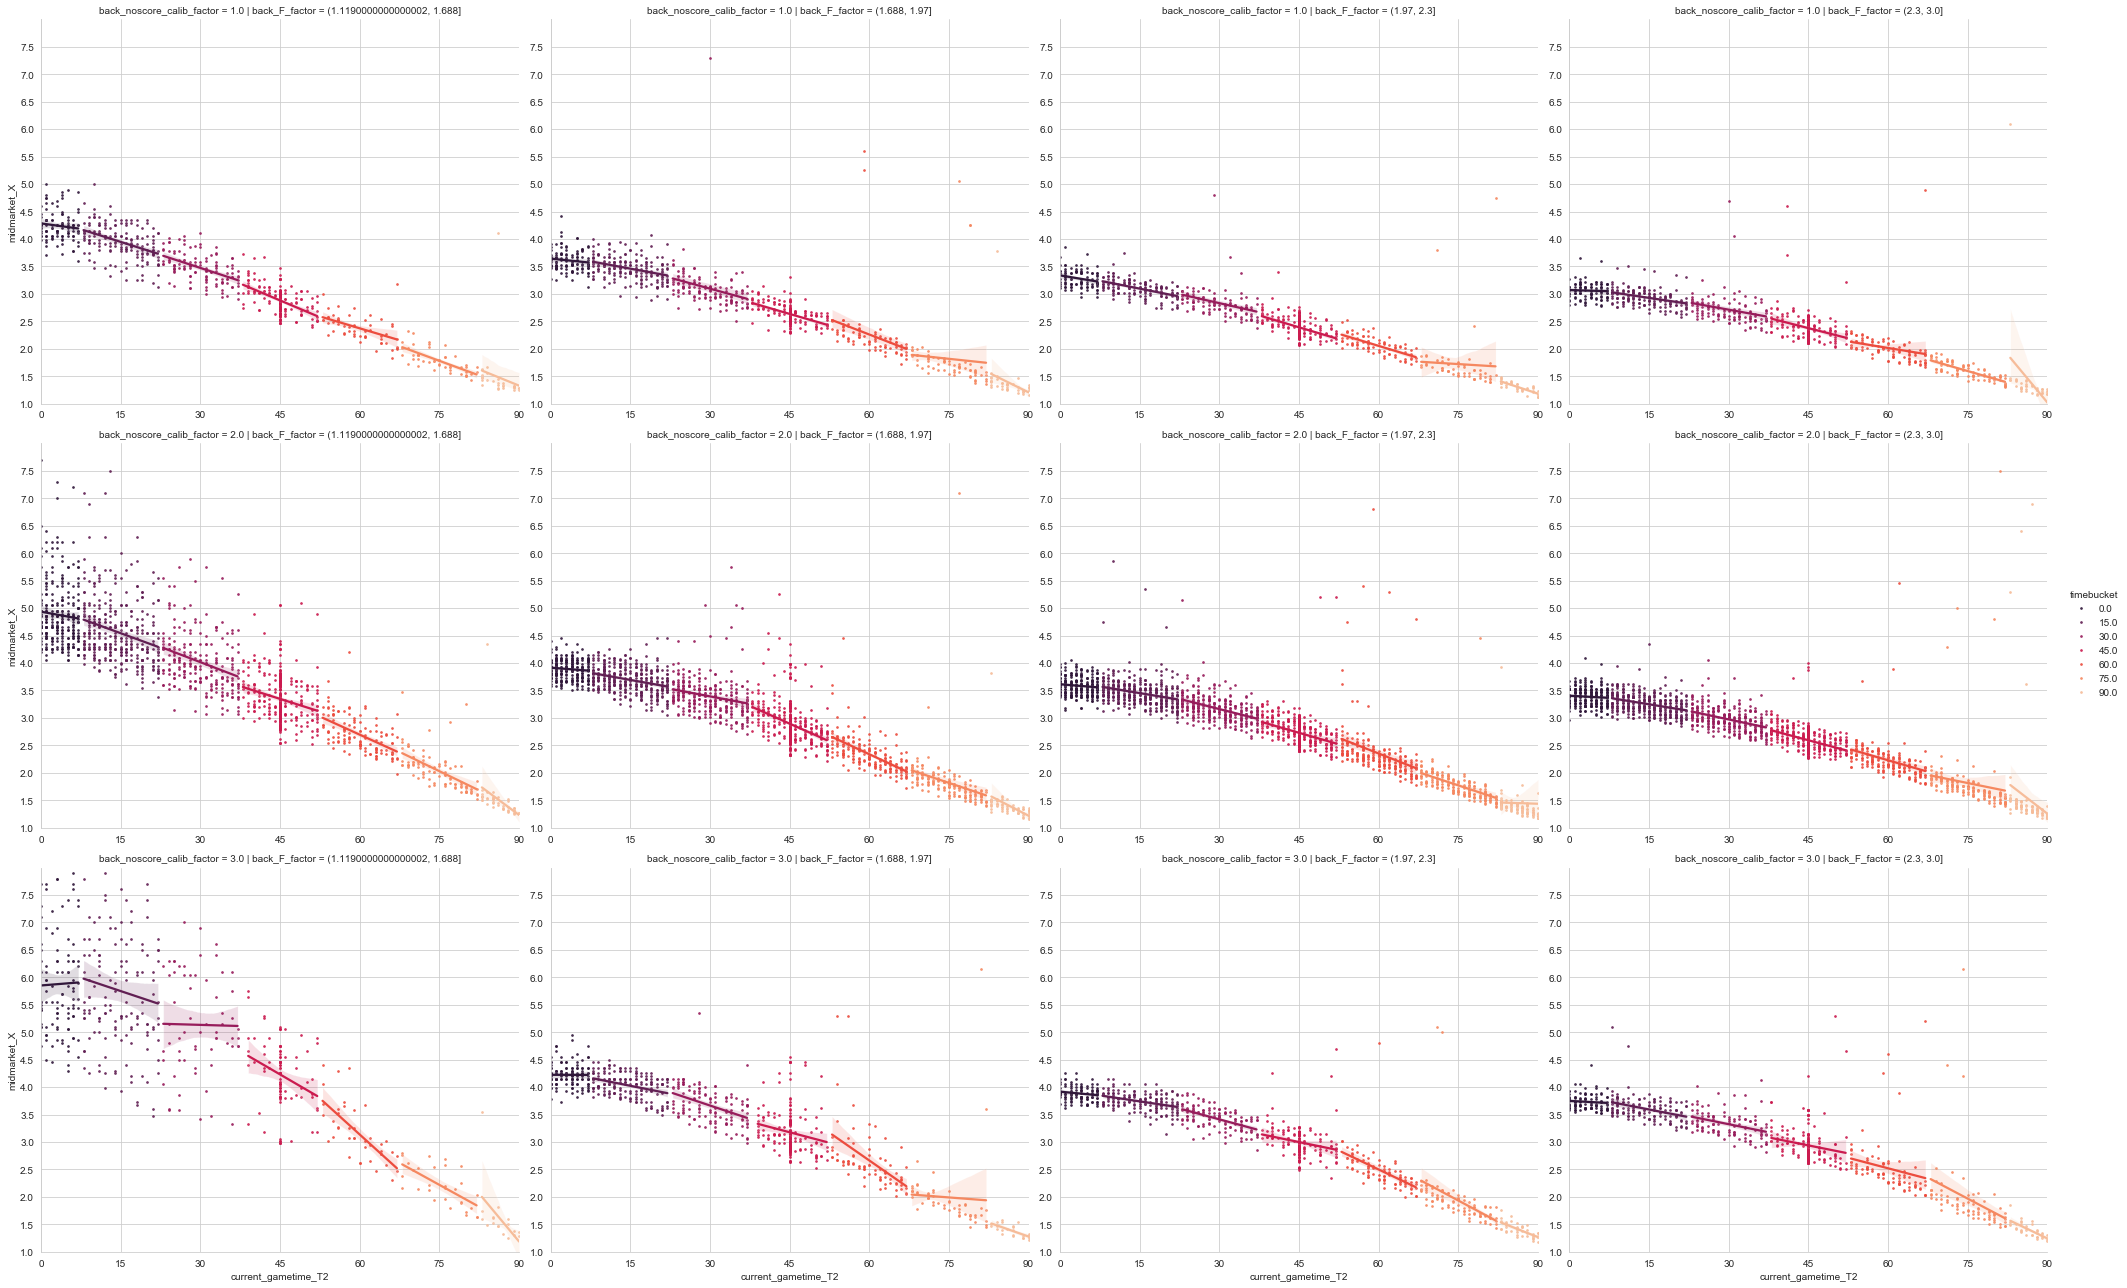

In [116]:
sns.set_style("whitegrid", {'axes.grid' : True})
g = sns.lmplot(data=df_sub, x='current_gametime_T2', y='midmarket_X', hue='timebucket', col='back_F_factor',
               row = 'back_noscore_calib_factor', scatter_kws = {'s':3}, aspect = 1.2, height=6, sharex=False, sharey=False,
              col_order = back_F_factor_order, palette="rocket")
g = (g.set(xlim=(0, 90), ylim=(1,8),
           xticks=[0,15,30,45,60,75,90], yticks=np.arange(1,8,0.5)))

In [117]:
g.savefig("./output/midmarket_X_estimates_timebuckets.png")

In [120]:
strat_1_count_pivots[4]

back_noscore_calib_factor,1,2,3,All
back_F_factor,,,,
"(1.189, 2.34]",18.0,40.0,20.0,78.0
"(2.34, 2.69]",19.0,36.0,17.0,72.0
"(2.69, 3.1]",16.0,44.0,18.0,78.0
"(3.1, 4.2]",16.0,39.0,17.0,72.0
All,69.0,159.0,72.0,300.0
